In [1]:
#imports
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import skimage.io
import datetime
import random
from scipy.signal import spectrogram

#PyTorch stuff
import torch
import torchvision as torchv
import torch.nn as nn 
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.datasets import ImageFolder

# File paths
TESTDIR = './../Data/Hyundai/'
TESTPATH = 'Lock/'
TESTSIG = 'keyfob_signal2023Y1022163258.raw'
TESTOUT = './../Data/MelSpec/Hyundai/'

IMG_SIZE=640
IMG_L = 640

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

classes = ('Lock', 'Unlock')

In [2]:
# Define the directory where Mel spectrogram images are stored
data_directory = TESTOUT

# Define data transformations
transform = transforms.Compose([transforms.Resize((IMG_SIZE,IMG_L)),
                                transforms.ToTensor()])

# Define the dataset using ImageFolder
dataset = ImageFolder(data_directory, transform=transform)

# Split the dataset into train and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders for training and validation
batch_size = 5
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [3]:
data_iterator = iter(train_loader)
images, labels = next(data_iterator)

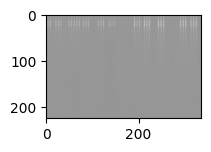

In [4]:
npimg = images[4].numpy()
# Display the image using matplotlib
plt.figure(figsize=(2,2))
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

In [5]:
def evaluation(dataloader):
    # calculate accuracy
    total, correct = 0,0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, pred = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return(100*correct/total)

In [6]:
class CNN_V1(nn.Module):
    def __init__(self):
        super(CNN_V1, self).__init__()

        # sequential similar to keras
        self.cnn_model = nn.Sequential(
            nn.Conv2d(3,3,5),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2,stride=2),
            nn.Conv2d(3,32,3),
            nn.ReLU(),
            nn.AvgPool2d(2,stride=2)
        )
        self.fc_model = nn.Sequential(
            nn.Linear(141696,512),
            nn.ReLU(),
            nn.Linear(512,2),
        )

    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0),-1)
        x=self.fc_model(x)
        return x

In [7]:
# Training

net = CNN_V1().to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
%%time
loss_arr = []
loss_epoch_arr = []
max_epochs = 25

for epoch in range(max_epochs):

    for i, data in enumerate(train_loader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        loss_arr.append(loss.item())

    loss_epoch_arr.append(loss.item())

    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (epoch, max_epochs, evaluation(val_loader), evaluation(train_loader)))

plt.plot(loss_epoch_arr)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("")
plt.show()